In [2]:
import os
import numpy as np
from pywt import cwt, wavedec, swt, WaveletPacket
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams.update({"font.size": 12, "font.weight": 'bold', "lines.linewidth": 1.5})
# os.chdir(r"C:\Users\grsah\Dropbox\Publications\Journal of Magnetic resonance\swt_fig")
#%matplotlib widget

In [3]:
def data_wcfs(data, wave, lev):
    """Returns the approximation and detail of coefficients of the data at all the decomposition level using "wavedec".

    Args:
        data (Numpy Array): 1D vector of the reference data.
        wave (String): Wavelet to be used for wavelet decomposition.
        lev (Intiger): Deomposition level till which signal will be decomposed.

    Returns:
        cf (List): Returns a list of approximation and detail coefficients.
    """

    app_ref, det_ref, cf = [], [], []
    for i in range(1, lev+1):
        c = wavedec(data=data, wavelet = wave, level=i)
        exec(f'app_ref.append(c[0])')
        exec(f'det_ref.append(c[1])')
    cf.append(app_ref)
    cf.append(det_ref)
    return cf

In [4]:
#Load the data
pds = np.loadtxt(r"C:\Users\gs582\Dropbox\Publications\PdF\Journal of Magnetic resonance\Data\pds_sim.txt")[:832, :]
pds30 = np.loadtxt(r"C:\Users\gs582\Dropbox\Publications\PdF\Journal of Magnetic resonance\Data\pds_sim30.txt")[:832]

# Calculate number of sampling pint, sampling frequency
N, deltaT = len(pds[:, 0]), (pds[1, 0]-pds[0, 0])

# Take Fourier transform of the data
fft_pds, fft_pds30 = rfft(pds[:, 1]), rfft(pds30)
fq = rfftfreq(N, deltaT)

# Take Short Time Fourier Transform of the data
# stft_fq, stft_t, stft_esr = stft(x=-1*data_esr[:, 1], fs=deltaT, window='hann', nperseg=256, noverlap=0)
# _, _, stft_esr30 = stft(x=data_esr30, fs=deltaT, window='hann', nperseg=256, noverlap=0)
seg = [0, 208, 416, 624]
stft_pds, stft_pds30 = np.empty((len(seg), len(fft_pds)), dtype=np.complex64), np.empty((len(seg), len(fft_pds)), dtype=np.complex64)

for i in range(len(seg)):
    tempd1, tempd2 = np.zeros((N)), np.zeros((N))
    tempd1[:208], tempd2[:208] = pds[seg[i]:seg[i]+208, 1], pds30[seg[i]:seg[i]+208]
    stft_pds[i, :], stft_pds30[i, :] = rfft(tempd1), rfft(tempd2)

In [5]:
# Frequency filtering
# Copy the data
fftbp_pds, fftbp_pds30 = np.copy(fft_pds), np.copy(fft_pds30)
fftgp_pds, fftgp_pds30 = np.copy(fft_pds), np.copy(fft_pds30)

# Perform low and high frequency filtering
#fftbp_esr[(freq_esr < np.max(freq_esr)/2)], fftbp_esr30[(freq_esr < np.max(freq_esr)/2)] = 0, 0
fftbp_pds30[(fq > (np.max(fq))/2)] = 0

# generate a Gaussian bandpass function
gaussp = np.exp(-((fq - min(fq))/(2*16))**2) + np.exp(-((fq - max(fq))/(2*16))**2)  # Possitive frequency
#gaussn = np.exp(-((fq + min(fq))/(2*0.1))**2) + np.exp(-((fq + max(fq))/(2*0.1))**2)  # Negative frequency
gaussf = gaussp #+ gaussn   # Only have possitive frequencies hence need to filter them only
fftgp_pds30 = fftgp_pds30*gaussf

# Reconstruct the data using inverse Fourier transform
databp_pds, databp_pds30 = irfft(fftbp_pds), irfft(fftbp_pds30)
datagp_pds, datagp_pds30 = irfft(fftgp_pds), irfft(fftgp_pds30)

# Take FT of the denoised data
ftbp_pds30, ftgp_pds30 = rfft(databp_pds30), rfft(datagp_pds30)

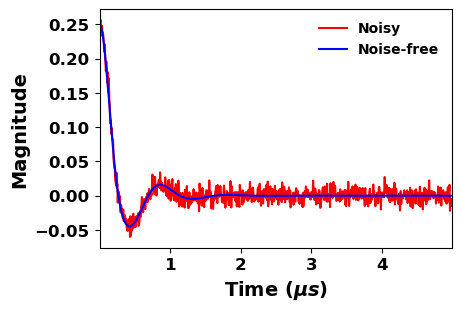

In [6]:
# Tiime domain pds Plot and save the data
plt.figure(figsize=(4.5, 3), dpi=100, layout='constrained')
# plt.plot(pds[:, 0], pds30[::-1], '-k', label='Noisy')
plt.plot(pds[:, 0], pds30, '-r', label='Noisy')
plt.plot(pds[:, 0], pds[:, 1], '-b', label='Noise-free')
plt.legend(frameon=False, fontsize=10, loc='upper right')
plt.xlim([(pds[0, 0]), (pds[831, 0])])
plt.xlabel('Time ($\\mu s$)', fontsize=14, fontweight='bold'), plt.ylabel('Magnitude', fontsize=14, fontweight='bold')
# plt.vlines(x=pds[207, 0], ymin=min(pds[:, 1])-0.01, ymax=max(pds[:, 1])+0.01, color='k', ls='--', lw=2)
# plt.vlines(x=pds[415, 0], ymin=min(pds[:, 1])-0.01, ymax=max(pds[:, 1])+0.01, color='k', ls='--', lw=2)
# plt.vlines(x=pds[623, 0], ymin=min(pds[:, 1])-0.01, ymax=max(pds[:, 1])+0.01, color='k', ls='--', lw=2)
# plt.savefig('pds.png', dpi=400, bbox_inches='tight', pad_inches=0.02)
plt.show()

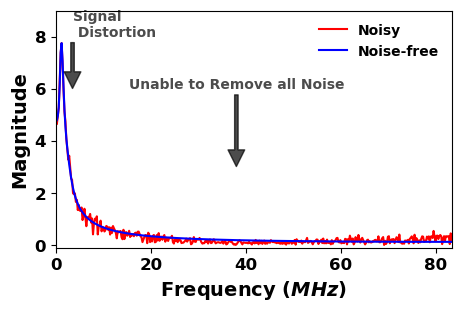

In [7]:
# Fourier transform plot
# Arrow properties
arprop, alp = dict(facecolor='black', shrink=0.005, width=2.5, alpha=0.7), 0.7

plt.figure(figsize=(4.5, 3), dpi=100, layout='constrained')
plt.plot(fq, abs(fftgp_pds30), '-r', label='Noisy')
plt.plot(fq, abs(fftgp_pds), '-b', label='Noise-free')
plt.legend(frameon=False, fontsize=10, loc='upper right')
plt.xlim([fq[0], fq[len(fq)-1]])
plt.ylim([-0.1, 9])
plt.xlabel('Frequency ($MHz$)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitude', fontsize=14, fontweight='bold')
plt.annotate('Signal \n Distortion', xy=(3.5, 6), xytext=(3.5, 8), xycoords='data', arrowprops=arprop, alpha=alp, ha='left', fontsize=10)
plt.annotate('Unable to Remove all Noise', xy=(38, 3), xytext=(38, 6.0), xycoords='data', arrowprops=arprop, alpha=alp, ha='center', fontsize=10)
#plt.savefig('ftpdsgp.png', dpi=400, bbox_inches='tight', pad_inches=0.02)
plt.show()

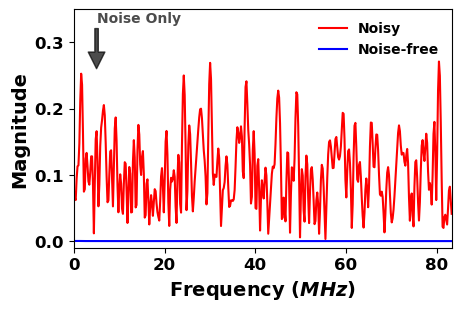

In [8]:
# Short Time Fourier Transform plot
# Arrow properties
arprop, alp = dict(facecolor='black', shrink=0.005, width=2.5, alpha=0.7), 0.7

plt.figure(figsize=(4.5, 3), dpi=100, layout='constrained')
plt.plot(fq, abs(stft_pds30[3, :]), '-r', label='Noisy')
plt.plot(fq, abs(stft_pds[3, :]), '-b', label='Noise-free')
plt.legend(frameon=False, fontsize=10, loc='upper right')
plt.xlim([fq[0], fq[len(fq)-1]])
plt.ylim([-0.01, 0.35])
plt.xlabel('Frequency ($MHz$)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitude', fontsize=14, fontweight='bold')
plt.annotate('Noise Only', xy=(5, 0.26), xytext=(5, 0.33), xycoords='data', arrowprops=arprop, alpha=alp, ha='left', fontsize=10)
#plt.annotate('Noise Only', xy=(3.0, 1.5), xytext=(3.0, 2.5), xycoords='data', arrowprops=arprop, alpha=alp, ha='center', fontsize=10)
#plt.savefig('stftpds4.png', dpi=400, bbox_inches='tight', pad_inches=0.02)
plt.show()

In [9]:
# Continuous Wavelet transform of the data
scale = np.arange(2, 45, 1)
cwt_pds, cfq_pds = cwt(data=pds[:, 1], scales=scale, wavelet='gaus3')
cwt_pds30, cfq_pds30 = cwt(data=pds30, scales=scale, wavelet='gaus3')

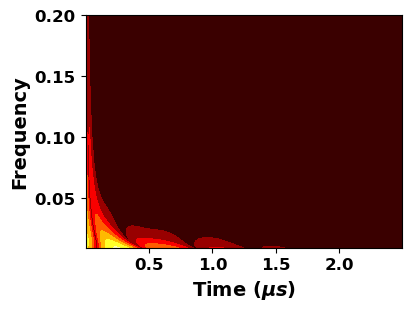

In [10]:
plt.figure(figsize=(4, 3), dpi=100, layout='constrained')
plt.contourf(pds[:416, 0], cfq_pds, abs(cwt_pds[:, :416])**0.5, cmap='hot')
#plt.contourf(pds[:416, 0], cfq_pds30, abs(cwt_pds30[:, :416])**0.5, cmap='hot')
plt.xlabel('Time ($\\mu s$)', fontsize=14, fontweight='bold')
#plt.ylabel('Scale', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()

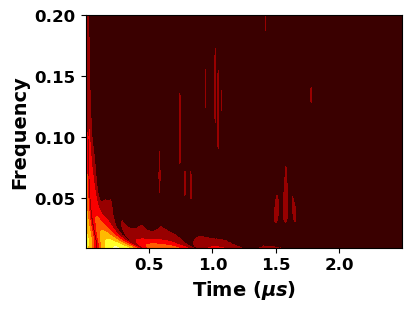

In [11]:
plt.figure(figsize=(4, 3), dpi=100, layout='constrained')
#plt.contourf(pds[:416, 0], cfq_pds, abs(cwt_pds[:, :416])**0.5, cmap='hot')
plt.contourf(pds[:416, 0], cfq_pds30, abs(cwt_pds30[:, :416])**0.5, cmap='hot')
plt.xlabel('Time ($\\mu s$)', fontsize=14, fontweight='bold')
#plt.ylabel('Scale', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()

In [12]:
# Statonary wavelet transform
dl=4
cf_db6, cf30_db6 = swt(data=pds[:, 1], wavelet='db6', level=dl), swt(data=pds30, wavelet='db6', level=dl)
cf_coif3, cf30_coif3 = swt(data=pds[:, 1], wavelet='coif3', level=dl), swt(data=pds30, wavelet='coif3', level=dl)
cf_sym10, cf30_sym10 = swt(data=pds[:, 1], wavelet='sym10', level=dl), swt(data=pds30, wavelet='sym10', level=dl)
cf_dmey, cf30_dmey = swt(data=pds[:, 1], wavelet='dmey', level=dl), swt(data=pds30, wavelet='dmey', level=dl)


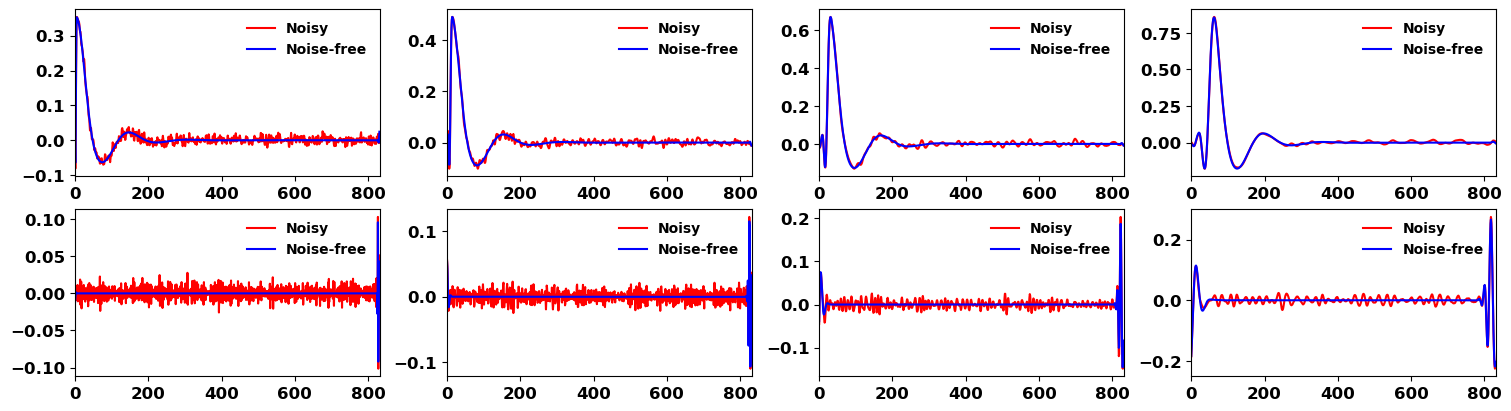

In [13]:
dt, dt30 = cf_db6, cf30_db6
fig = plt.figure(figsize=(15, 4), dpi=100, layout='constrained')
gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
ax = gs.subplots(sharex=False, sharey=False)
for i in range(1, 5):
    ax[0, i-1].plot(dt30[-i][0], '-r', label='Noisy'), ax[0, i-1].set_xlim(0, 832), ax[0, i-1].legend(frameon=False, fontsize=10, loc='upper right')
    ax[0, i-1].plot(dt[-i][0], '-b', label='Noise-free'), ax[0, i-1].set_xlim(0, 832), ax[0, i-1].legend(frameon=False, fontsize=10, loc='upper right')

    ax[1, i-1].plot(dt30[-i][1], '-r', label='Noisy'), ax[1, i-1].set_xlim(0, 832), ax[1, i-1].legend(frameon=False, fontsize=10, loc='upper right')
    ax[1, i-1].plot(dt[-i][1], '-b', label='Noise-free'), ax[1, i-1].set_xlim(0, 832), ax[1, i-1].legend(frameon=False, fontsize=10, loc='upper right')

plt.show()

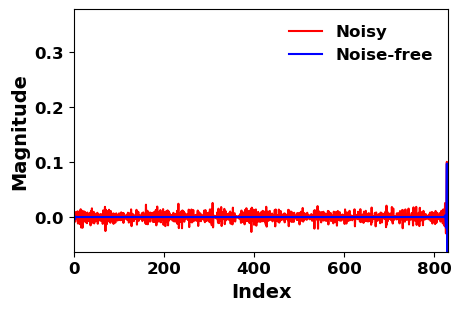

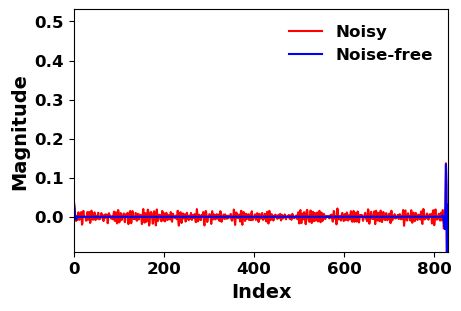

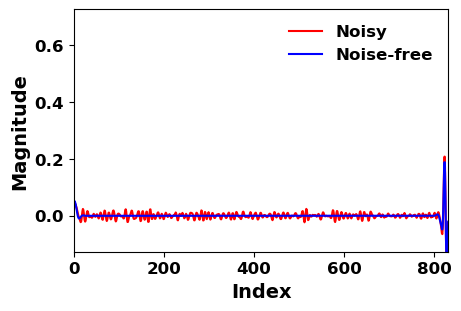

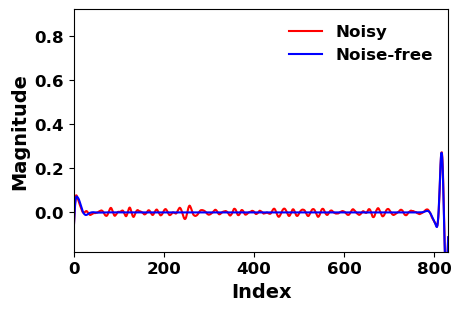

In [14]:
# Save wavelet coefficients
dt, dt30 = cf_coif3, cf30_coif3
for i in range(1, dl+1):
    plt.figure(figsize=(4.5, 3), dpi=100, layout='constrained')
    plt.plot(dt30[-i][1], '-r', label='Noisy')
    plt.plot(dt[-i][1], '-b', label='Noise-free')
    plt.legend(frameon=False, loc='upper right')
    plt.xlim([0, len(pds[:, 1])-1])
    plt.xlabel('Index', fontsize=14, fontweight='bold')
    plt.ylabel('Magnitude', fontsize=14, fontweight='bold')
    plt.ylim([min(dt[-i][0]), max(dt[-i][0])])
    #plt.xticks([])
    #plt.yticks([])
    # plt.savefig('pdsdet_{i}.png'.format(i=i), dpi=400, bbox_inches='tight', pad_inches=0.02)

    plt.show()



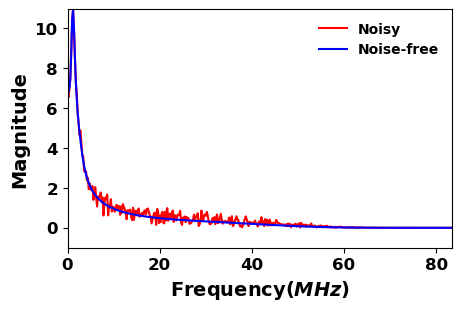

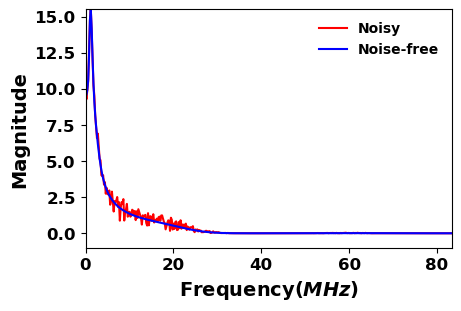

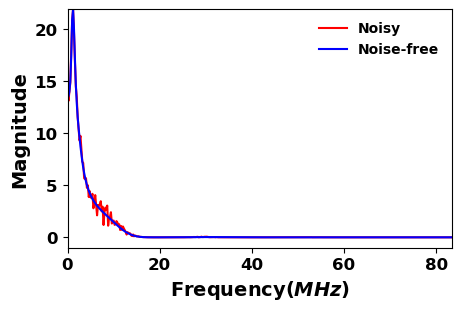

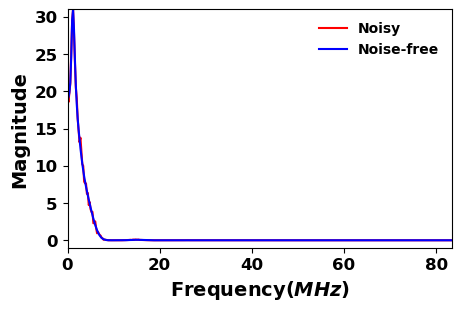

In [15]:
# Plot and save FT of wavelet coefficients
dt, dt30 = cf_coif3, cf30_coif3
for i in range(1, 5):
    plt.figure(figsize=(4.5, 3), dpi=100, layout='constrained')
    plt.plot(fq, abs(rfft(dt30[-i][0])), '-r', label='Noisy')
    plt.plot(fq, abs(rfft(dt[-i][0])), '-b', label='Noise-free')
    plt.legend(frameon=False, fontsize=10)
    plt.xlim([fq[0], fq[len(fq)-1]])
    plt.xlabel('Frequency($MHz$)', fontsize=14, fontweight='bold')
    plt.ylabel('Magnitude', fontsize=14, fontweight='bold')
    plt.ylim([min(abs(rfft(dt30[-i][0])))-1, max(abs(rfft(dt30[-i][0])))])
    #plt.annotate('Signal \n Distortion', xy=(0.85, 3.5), xytext=(0.85, 6.6), xycoords='data', arrowprops=arprop, alpha=alp, ha='center', fontsize=10)
    # plt.savefig('ftpdsapp_{i}.png'.format(i=i), dpi=400, bbox_inches='tight', pad_inches=0.02)

    plt.show()

In [16]:
wp_db6, wp_coif3 = WaveletPacket(data=pds[:, 1], wavelet='db6', maxlevel=3), WaveletPacket(data=pds[:, 1], wavelet='coif3', maxlevel=3)
wp30_db6, wp30_coif3 = WaveletPacket(data=pds30, wavelet='db6', maxlevel=3), WaveletPacket(data=pds30, wavelet='coif3', maxlevel=3)

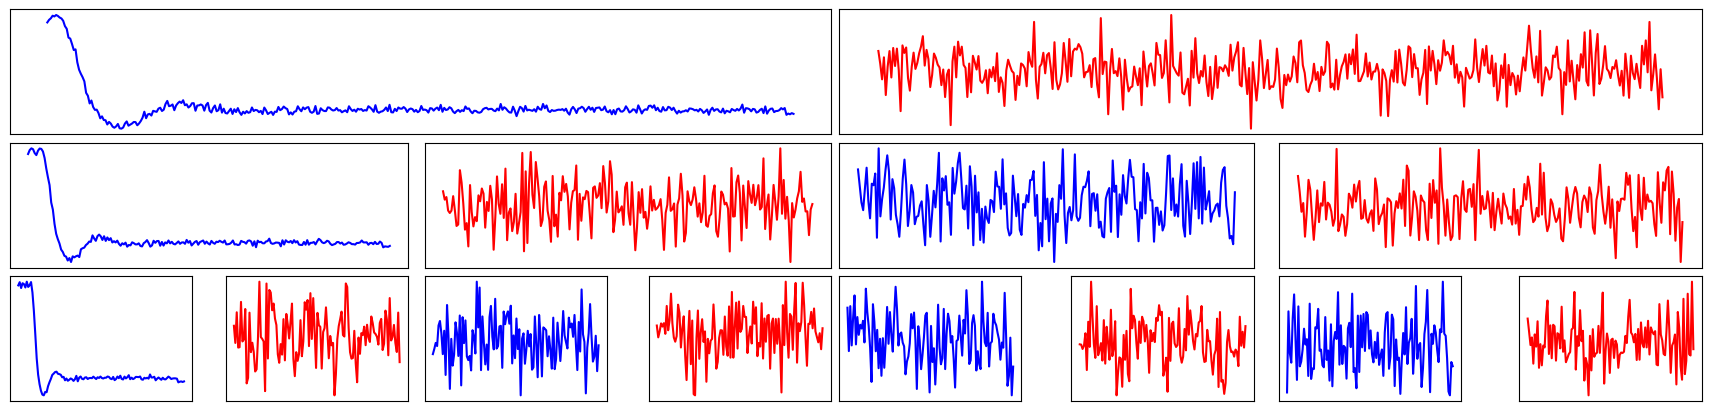

In [17]:
dt = wp30_coif3

fig = plt.figure(figsize=(17, 4), dpi=100, constrained_layout=True)
gs = fig.add_gridspec(3, 8, hspace=0, wspace=0)
ax1, ax2 = fig.add_subplot(gs[0, 0:4]), fig.add_subplot(gs[0, 4:])
ax3, ax4, ax5, ax6 = fig.add_subplot(gs[1, :2]), fig.add_subplot(gs[1, 2:4]),fig.add_subplot(gs[1, 4:6]), fig.add_subplot(gs[1, 6:])
for i in range(7, 15):
    exec(f'ax{i} = fig.add_subplot(gs[2, i-7])')
# ax7, ax8, ax9, ax10 = fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1]),fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[2, 3])
# ax11, ax12, ax13, ax14 = fig.add_subplot(gs[2, 4]), fig.add_subplot(gs[2, 5]),fig.add_subplot(gs[2, 6]), fig.add_subplot(gs[2, 7])

ax1.plot(dt['a'].data, '-b'), ax2.plot(dt['d'].data, '-r')
ax3.plot(dt['aa'].data, '-b'), ax4.plot(dt['ad'].data, '-r'), ax5.plot(dt['da'].data, '-b'), ax6.plot(dt['dd'].data, '-r')
ax7.plot(dt['aaa'].data, '-b'), ax8.plot(dt['aad'].data, '-r'), ax9.plot(dt['ada'].data, '-b'), ax10.plot(dt['add'].data, '-r')
ax11.plot(dt['daa'].data, '-b'), ax12.plot(dt['dad'].data, '-r'), ax13.plot(dt['dda'].data, '-b'), ax14.plot(dt['ddd'].data, '-r')

for i in range(1, 15):
    exec(f'ax{i}.set_xticks([])')
    exec(f'ax{i}.set_yticks([])')

plt.show()